# LIGHTGBM

In [1]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.utils import load_data, save_model, save_metrics, evaluate, save_figure, get_oof_preds
from src.models import get_model
from src.tuning import search_params

try:
    if Path(os.getcwd()).name == 'notebooks':
        os.chdir('..')
except: pass

# 1. LOAD DATA

In [2]:
X, y = load_data()

print(f"Shape của tập X_train: {X.shape}")
print(f"Shape của tập y_train: {y.shape}")
print("\n5 dòng đầu của X (Features):")
X.head()

Shape của tập X_train: (1458, 338)
Shape của tập y_train: (1458,)

5 dòng đầu của X (Features):


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.227075,19.212182,7,2003,2003,8.059126,11.170327,0.0,2.520750,856.0,...,False,False,False,True,False,False,False,False,True,False
1,2.301430,19.712205,6,1976,1976,0.000000,12.062832,0.0,2.735757,1262.0,...,False,False,False,True,False,False,False,False,True,False
2,2.243319,20.347241,7,2001,2002,7.646538,10.200343,0.0,2.875008,920.0,...,False,False,False,True,False,False,False,False,True,False
3,2.198137,19.691553,7,1915,1970,0.000000,8.274266,0.0,2.945797,756.0,...,False,False,False,True,True,False,False,False,False,False
4,2.318756,21.325160,8,2000,2000,9.391827,10.971129,0.0,2.914398,1145.0,...,False,False,False,True,False,False,False,False,True,False


# 2. KHỞI TẠO MÔ HÌNH VÀ HUẤN LUYỆN MÔ HÌNH LIGHTGBM

In [3]:
model_name = 'lightgbm'
param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31],
    'feature_fraction': [0.7, 0.9],
    'bagging_fraction': [0.7, 0.9],
}
print("-" * 66)
print("    Bắt đầu tìm kiếm siêu tham số cho mô hình LightGBM")
print("-" * 66)

# Tìm tham số tốt nhất cho mô hình LightGBM
base_model = get_model(model_name)
best_model, best_params = search_params(base_model, param_grid, X, y)
model = best_model

# Tính toán OOF dự đoán dựa trên mô hình đã được tối ưu
oof_pred = get_oof_preds(model, X, y) 

print("Huấn luyện hoàn tất.")

------------------------------------------------------------------
    Bắt đầu tìm kiếm siêu tham số cho mô hình LightGBM
------------------------------------------------------------------
Bắt đầu Tuning (grid)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best RMSE: 0.1247
Best Params: {'bagging_fraction': 0.7, 'feature_fraction': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 31}
Huấn luyện hoàn tất.


# 3. ĐÁNH GIÁ HIỆU SUẤT

In [4]:
metrics = evaluate(y, oof_pred)

print(f"\n{model_name.upper()} Metrics (OOF):")
print("-" * 30)
for metric, value in metrics.items():
    if isinstance(value, np.float64):
        value = float(value)
    print(f"  - {metric.upper()}: {value:.4f}")

save_metrics(model_name, metrics)
print("-" * 30)
print("Kết quả đã được lưu vào results/metrics.json")


LIGHTGBM Metrics (OOF):
------------------------------
  - RMSE: 0.1250
  - MAE: 0.0850
  - R2: 0.9021
------------------------------
Kết quả đã được lưu vào results/metrics.json


# 4. TRỰC QUAN HOÁ KẾT QUẢ

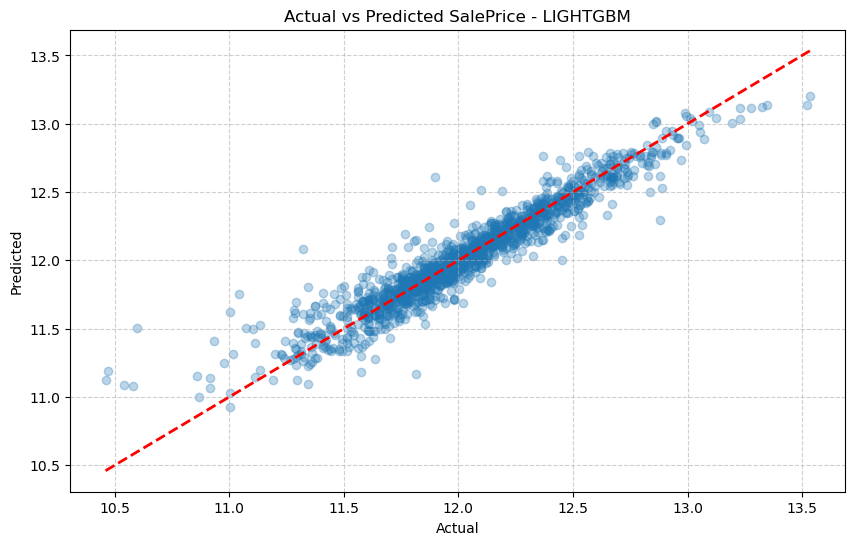

Hình ảnh đã lưu thành công tại: results/figures/lightgbm_actual_vs_predicted.png


In [5]:
filename_to_save = 'lightgbm_actual_vs_predicted.png' 
figure_path = f'results/figures/{filename_to_save}' 

fig, ax = plt.subplots(figsize=(10, 6)) 

ax.scatter(y, oof_pred, alpha=0.3)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title(f'Actual vs Predicted SalePrice - {model_name.upper()}')
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()
save_figure(fig, filename=filename_to_save) 



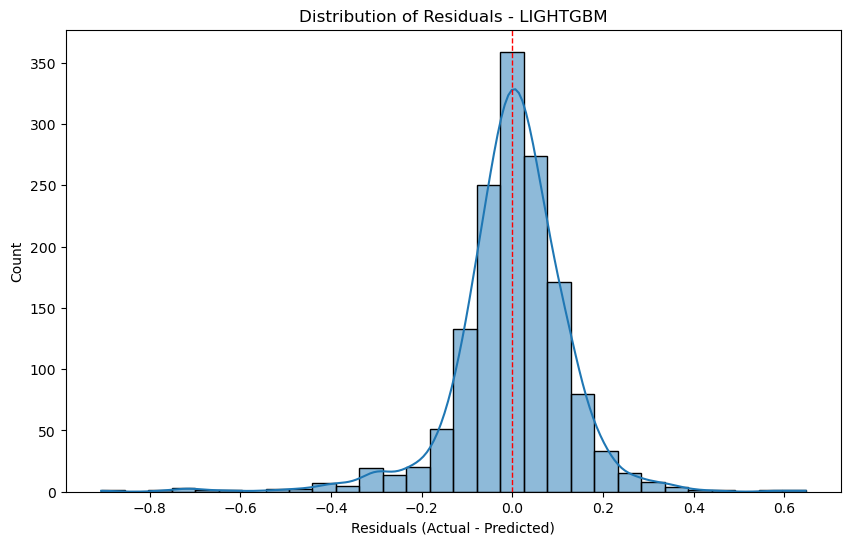

Hình ảnh đã lưu thành công tại: results/figures/lightgbm_actual_vs_predicted.png


In [6]:
residuals = y - oof_pred
figure_path_res = 'results/figures/lightgbm_residuals.png'

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title(f'Distribution of Residuals - {model_name.upper()}')
plt.savefig(figure_path_res)
plt.show()

save_figure(fig, filename=filename_to_save) 

# 5. LƯU MODEL 

In [7]:
save_model(best_model, model_name)
print(f"Mô hình {model_name} đã được lưu thành công tại models/{model_name}.pkl")

Mô hình lightgbm đã được lưu thành công tại models/lightgbm.pkl


Exception ignored in: <function ResourceTracker.__del__ at 0x10646de40>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102299e40>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1027b5e40>
Traceback (most recent call last